# Python入門講座(第13 & 14 回)：外の世界と繋がろう¶
 
 プログラムから実際のハードウェアを制御する方法の一つとして、電子計算機の初期からいまも使われている
 シリアル通信があります。今回はこのシリアル通信を使って実際のハードウェアを操作するプログラムを
 Pythonを使って作成してみましょう。

## 今日の目標
今回は、EPICS講習会などで使われたArduinoをベースにした簡単な装置を、Pythonのプログラムから制御する方法を見ていきます。
この装置を使うことで、計算機からハードウェアを制御するために バイナリ、アナログのデータをやりとるする方法の基礎を経験することができます。

### 内容

 1. シリアル通信って何？
 1. pyserial モジュール
 1. Arduinoベースの試験装置を制御するPythonプログラム

## シリアル通信の概要

電子計算機で装置を制御する際には、計算機と装置とのデータを交換する方法としてパラレル方式とシリアル方式があります。パラレル方式では複数のビットデータを、そのビット数に応じた信号線を使って同時にそのデータを送受信する方法です。一方、シリアル方式では一本の通信線に複数のビットデータを時間的に分割して順次送信します。

[パラレル方式とシリアル方式]: _images/Serial-or-Parallel-communications.png

![パラレル方式とシリアル方式][パラレル方式とシリアル方式]

シリアル通信では、データは時間にそって順次伝わっていきます。パラレル通信では、複数の信号線を使うことで一組みのデータが同時に送信されます。
パラレル通信は信号線の数を増やせば、短時間に大量のデータを送ることができるので高速通信に有利ですが、信号線が長くなってくると複数の信号線を伝わる信号の時間差（スキュー）が問題となってくるのでシリアル通信が有利ということが言えるでしょう。

信号伝達／信号処理に使われる周波数が高くなってくるにつれ、”長距離”の概念も変わってきます。

電気信号を使った通信が実用化された当初はシリアル通信といえば、モールス信号やテレタイプあるいは電話線をつかったモデムによる通信と
いった数10メートルかkmオーダの応用が中心でした。10メートル程度であればGP-IB(IEE-488)やCAMACなどでは、パラレル通信もつかわれていました。

現在では、計算機と周辺装置の間では USB(Universal Serial Bus),IC間の接続でもI2(Inter-Integrated Circuit,I-squared-C)CやSPI(serial peripheral interface) というように、シリアル通信の利用が中心となっています。

（注：SPI:Synthetic Personality Inventory（総合適性検査）とは別物です。）

### EIA-232(RS-232) 規格

EIA-232(RS-232)はUSBが普及する以前に広くつかれていたシリアル通信規格です。 DB(D-Sub)-25pinあるいはDB-9(DE-09)pinのケーブルで機器(DTE:data terminal equipment)と通信装置(DCE:data communication equipment, MODEM:Modulator-Demodulator)を接続するために使われていました。 
TxDおよびRxDの信号線の他に、DTR(Data Terminal Ready), DCD(Data Carrier Detect), DSR(Data Set Ready),RTS/RTR(Request To Send/Ready to Receive), CTS(Clear To Send) といった通信制御のための信号線を持っています。

![DCEとDTEの関係](./_images/EIA232_system_configuration.png)

注：DB-9：D-sub コネクターの9pin版。正しくはDE-9らしい。(D-subにはDA-DEの5タイプと3種類のDensityによる分類がある）。 アストンマーチン DB-9とは無関係

### EIA-232(RS232-C) 信号の方向と接続の関係

初期のPCでは、EIA-232の信号(制御信号を含む）をサポートするために、DB-9コネクタが標準的に使われていました。制御信号を省くことで3芯のケーブル(Tx/Rx/GND)でも通信は可能となるので、その他のコネクタ（RJ-45など）が使われる場合もありました。

[DCEとDTEの関係]: ./_images/EIA232_signal_connections.png

![DTEとDTEの信号の関係](./_images/EIA232_signal_connections.png)

## DCD信号
DCD信号はDCEからDTEに電話回線などの通信回路が接続済みであることを通知するために使われます。

### クロスケーブルによるDTE-DTE接続
DTE-DTE間の距離によっては、ケーブルによる直接接続も可能です。この場合にはクロスケーブルと呼ばれる接続のケーブルが使われます。上図の点線の結線がクロスケーブルでは使われます。


### 変換ケーブル／コネクタの例
シリアル接続用ケーブルの一例として、USB-Serial変換ケーブルの一例（写真左）を示します。ケーブルの一端にUSB- Aコネクタ、反対の一端にはDB-9コネクタがUSB-Serial変換機能を持つ中央部を経由して接続されています。
写真右は同様のUSB-GPIB変換ケーブルです。GP-IBのコネクタはアンフェノール社が設計した24ピンのマイクロリボンコネクタになっています。GP-IBはパラレル接続ですので、EIA-232に比べ信号線の数が増えています。
![USB Serial converter](./_images/cables-connectors.png)

### IEEE-488
パラレル通信の一つの例としてIEE-488(GP-IB)規格があります。

IEEE-488規格はGPI-IB/HP-IBに起源をもつ、機器制御の国際規格です。現在のIEEE-488規格はIEEE-488.1, IEEE-48.2の二つの規格に分かれています。IEEE-488.1はGP-IBの電気的な規格を定めています。一方、IEEE-488.2はこの規格に従う機器の制御で使われるコマンドやデータのフォーマット、標準的なコマンドについて規定しています。IEEE-488.2は関連するSCPI
ともに計算機と計測機器の間の通信のためのコマンドやデータのフォーマット、標準コマンドな度を規定しており、VXI11, HiSLIP, USBTMCなどのシリアル通信を使った方式でも採用されています。

[IEEE 488.1-1987 (IEEE Standard Digital Interface for Programmable Instrumentation)]: https://standards.ieee.org/ieee/488.1/715/

[IEEE 488.2-1992 IEEE Standard Codes, Formats, Protocols, and Common Commands for Use With IEEE Std 488.1-1987, IEEE Standard Digital Interface for Programmable Instrumentation]: https://standards.ieee.org/ieee/488.2/718/

# Serialモジュール
Pythonでシリアル通信を取り扱うための基本モジュールは`PySerial`モジュールです。標準配布のモジュールではありませんので、PyPIからインストールします。

お使いの環境によっては、すでにインストール済みあるいはその環境のパッケージ管理システム(apt, yum/dnfなど）をつかってインストールすることも可能でしょう。

## `pyserial`モジュールのインストール

PIPを使う方法

```shell
python3 -m pip install pyserial
```

yum/dnf(Redhat系Linux, RH, Centなど）

```shell
yum install pyserial
```

## `pyserial`モジュールのインポート

配布パッケージの名前は`pyserial`ですが、python モジュールとしての名前は`serial`となっています。したがって、
``` python
from serial import *
```

あるいは
``` python
from serial import Serial
```
などで、必要なクラスをインポートします。

なお、このノートで使用している`pyserial`のバージョンは次のようになっています。異なるバージョンの`pyserial`では一部のプログラムで変更が必要なものがあります。

In [1]:
import serial
print(serial.__version__)

3.5


### `pyserial`のサブモジュール
`pysieral`には、次のようなサブモジュールが用意されています。

 1. `rs485` : RS485(multidropのシリアル通信）
 1. `rfc2217`: "Telnet Com Port Control"　TCP-serialコンバーターによるシリアル通信
 1. serial.tools.list_ports: `comports()`などシリアルポートの検索、詳細情報の入手などいくつかのツール
    * 後で使い方の例をご紹介します。
 1. serial.tools.miniterm :簡易ターミナルアプリケーション
                    


# 今回使用する試験装置の概要
ここで使う装置は、

 * マイクロコントローラと入出力／周辺回路を一枚の基盤に実装したArduinoに、入出力の見本として、
   * LED, サーミスタ(温度センサ), CdS(明るさセンサ), スイッチ, ブザーを接続してあります。
 * これらの素子より、このボードを使って DI, DO, AO, AI の基本的な入出力を試してみることができます。
 * このArduinoにはすでにこの講座用のプログラム（スケッチ）がダウンロードされており、USB端子に接続すると動作を始めます。
 * Arudinoと制御用のPCのUSBの接続はCDC(Communication Device Class)で行われます。
 * この結果、PCからは、Arduinoはシリアル通信で接続されたTTYデバイス(USBCDCデバイス）として認識されています。

[試験装置概要]: ./_images/制御テスト装置概要.png

![試験装置の概要][試験装置概要]

この試験装置には、["gainermodoki32u"](./gainermodoki32u.ino)プログラム(Arduinoではスケッチと呼ばれます）が予めダウンロードされています。このプログラムが起動しているAruduinoは一文字のコマンドと二つまでの引数の組み合わせで、接続されている素子を操作することができます。

|コマンド文字|引数|意味|
|-:|:-:|:-|
|H |pin番号(D)| ビット出力を1にする|
|L |pin番号(D)| ビット出力を0にする|
|R |pin番号(D)| ビット入力を読み込む|
|a |pin番号(D)+出力値 | PWM出力値設定|
|S |pin番号(A)| アナログ入力値を読み込む|
|M or ?| NA | バージョン番号|

コマンドで使われるピン番号と接続されている素子の関係は次の様になっています。

表：コマンド引数のピン番号と素子の端末との関係

| pin | signal | pin | signal|
| -: | :- | -: | :- |
| D3(PWM/AO) | 3-LED(R) | D2(DO) | Buzzer |
| D5(PWM/AO) | 3-LED(G) | D7(DI) | Button(SW) |
| D6(PWM/AO) | 3-LED(B) | D８/D12(DI) | 傾き(Tilt)スイッチ |
| D9(PWM/AO) | LED(G) | A0(AI) | Cds |
| D10(PWM/AO)| LED(R) |  A1(AI) | Thermistor | 
| D13(DO) | On boad LED | A5(AI) | Vdd |

## Arduinoアプリを使った動作の確認
`Arduino`ボードの開発環境 `Arduino`アプリにはシリアル モニタ機能が付属しています。

この機能を使って試験装置の動作を確認してみます。

[Arduino　スクリーンモニタ]:_images/Arduino-Serial-monitor.png
[movie]: http://www-cont.j-parc.jp/members/yamamoto/movies/Python_Lectures/2022-03-07_16.21.53.m4v

[![Arduino　スクリーンモニタ]][movie]

## USB-CDC接続

少し前までのPCには、Serial Port(EIA-232(RS-232))のDSUB-9pinコネクタを持っているものも少なくありませんでした。しかし、2022年現在のPCではそういったPCは滅多にお目にかかりません。したがって、最近のPCをシリアル接続しか受け付けない装置と接続しようとすると、USB-シリアルコンバータやネットワーク経由のターミナルサーバーをつかうことになります。

USB-CDC(Communication Device Class)はUSB-Serialコンバーター/USB-UART(Universal Asynchronous Receiver/Transmitter)経由でシリアル通信を行う際に使われる規格です。

今回使用しているArduino UNOにはメインのCPU(ATMEGA328P-PU)の他に、main CPUとUSBportの間にあって、USB-Serial コンバータの役割を果たしている副CPU(ATMEGA16U2-MU)が搭載されています。これによって、Arduino UNOは別途コンバータを用意することなく、USB-CDCデバイスとして働きます。(Arduinoのバージョンによっては、別途USB-Serial コンバーターを用意する必要があります。）

### デバイスファイル名の確認

USB-CDCで接続された装置は、OSからシリアル通信装置(tty,cu:calling unit)として認識され、デバイスファイルが`/dev`以下に登録されます。登録されるデバイスファイル名はOSに依存します。

* `macos`の場合は次のようになります。接続されたUSBポートを示す番号がデバイスファイル名に含まれています。
``` shell
% ls -l /dev/tty*usb*
crw-rw-rw-  1 root  wheel  0x9000002  3  1 09:51 /dev/tty.usbmodem1101
```


* Linuxでは、`/dev/serial/by-id`を調べることで、接続された装置がどのデバイスファイルに結びついているかを確認できます。
``` shell
$ ls -l /dev/serial/by-id
合計 0
lrwxrwxrwx. 1 root root 13 Feb 11 07:41 usb-Arduino_LLC_Arduino_Micro-if00 -> ../../ttyACM2
lrwxrwxrwx. 1 root root 13 Feb 18 09:45 usb-Arduino__www.arduino.cc__0043_64936333037351904041-if00 -> ../../ttyACM4
lrwxrwxrwx. 1 root root 13 Feb 11 07:41 usb-Arduino__www.arduino.cc__0043_9314036423335140F032-if00 -> ../../ttyACM3
```

[pyserial docs]: https://pyserial.readthedocs.io/en/latest/pyserial_api.html

注：
Linuxの`/dev/serial` ディレクトリには、`/dev/serial/by-id`と`/dev/serial/by-path`の二つのサブディレクトリがあります。`/dev/serial/by-path`には、デバイスが接続されたポート名の名前がデバイスファイル名として登録されます。

``` shell
 $ ls -l /dev/serial/by-path
 /dev/serial/by-path:
  ...
  lrwxrwxrwx. 1 root root  13 Mar  2 08:02 pci-0000:00:14.0-usb-0:1.3.1:1.0 -> ../../ttyACM0
  lrwxrwxrwx. 1 root root  13 Mar  2 08:02 pci-0000:00:14.0-usb-0:1.3.3:1.0 -> ../../ttyACM1
  lrwxrwxrwx. 1 root root  13 Mar  2 14:43 pci-0000:00:14.0-usb-0:1.3.4:1.0 -> ../../ttyACM3
  ...
```
Linuxでは`/dev/serial/by-id`あるいは`/dev/serial/by-path`中のデバイスファイル名と`/dev/`中の`ttyACM`名との対応は
システムブートの前後で異なっていることがあります。その意味で,　`/dev/ttyACM`の名前をプログラム中で直接使うより、`/dev/serial/by-id`あるいは`/dev/serial/by-path`中の名前を使う方が良いでしょう。

### デバイスファイル名の取得

`glob`モジュールや、`os`モジュール、`fnmatch`モジュール、`re`モジュールを使って、 Arduino装置がOSに認識されているかを
確認してみましょう。
`glob.glob()`は引数に与えられたパス名のパターンに合致するファイルの***パス名のリスト***を返します。

In [5]:
import glob
glob.glob("/dev/tty*usb*") # Linuxでは、"/dev/ttyACM*"などとしてみましょう。

['/dev/tty.usbmodem1101']

`glob.glob()`関数の返す値はデバイスファイル名の**リスト**なので、最初の要素`[0]`だけを取り出します。

In [3]:
ttydev=glob.glob("/dev/tty*usb*")[0]
ttydev

'/dev/tty.usbmodem11101'

`os`モジュールの`listdir`関数は引数に指定されたパスに在る ***ファイル名のリスト*** を返します。
その中から、`fnmatch`モジュールの`fnmatch`関数を使ってパターンに合致する***ファイル名***だけを選び出します。

In [4]:
import os, fnmatch
[file for file in os.listdir("/dev/") if fnmatch.fnmatch(file, 'tty*usb*')] # unix pattern

['tty.usbmodem11101']

正規表現(regular expression)を使ってファイル名のリストから選択することもできますね。
(パターン "tty\*usb\*" と正規表現 "tty.\*usb.\*" の違いに注意してください。）

In [5]:
import os, re
[file for file in os.listdir("/dev/") if re.match('tty.*usb.*',file)] # regular expression

['tty.usbmodem11101']

### Windowsの場合

Windowsではシリアル通信のデバイスは`"COM2"`などの名前で指定します。この名前と実際に接続されている装置の対応については、Windowsのマニュアルをご覧ください。

## `serial.tools.list_ports` モジュール
`pyserial`モジュールで操作可能なポートのリストを入手するには、
`serial.tools.list_pots`モジュールの`grep()`や`comports()`を使うことも可能です。
このモジュールを使うことで、より詳細なポートの情報を入手可能です。(platformによる, macosxではポートの詳細情報が得られない。→ pyserial 3.5では修正済）Linuxでの使用例を示します。

shellで直接確認することもできます。

### macosの場合

```　bash
$ python3 -m serial.tools.list_ports_osx
/dev/cu.AUKEYBR-C1: n/a [n/a]
/dev/cu.Bluetooth-Incoming-Port: n/a [n/a]
/dev/cu.usbmodem11101: Arduino Uno [USB VID:PID=2341:0001 SER=6493534363335151A102 LOCATION=1-1.1]
/dev/cu.wlan-debug: n/a [n/a]
```

### linuxの場合：

``` bash
$ python3 -m serial.tools.list_ports_linux
/dev/ttyACM0: USB-ADC AD7793 CQ Board [USB VID:PID=04D8:0FBA LOCATION=3-1.3.1:1.0]
/dev/ttyACM1: USB-ADC AD7793 CQ Board [USB VID:PID=04D8:0FBA LOCATION=3-1.3.3:1.0]
/dev/ttyACM2: Arduino Micro [USB VID:PID=2341:8037 LOCATION=3-4.3:1.0]
/dev/ttyACM3: ttyACM3 [USB VID:PID=2341:0043 SER=9314036423335140F032 LOCATION=3-1.3.4:1.0]
```
（お願い：`serial.tools.list_ports_windows`をwindows PC上で実行した結果をお知らせください。）

pythonプログラム中の`serial.tools.list_ports.comports()`使用例：

In [6]:
import serial.tools.list_ports
for port, desc, hwid in serial.tools.list_ports.comports():
    print(port, desc, hwid)
    
print("\n serial.tools.list_ports.grep examples\n")
# serial.tools.list_ports.grep を使って、デバイス名、 description あるいは hwid に指定文字列を含むもの
for port, desc, hwid in serial.tools.list_ports.grep("usb"):
    print (port, desc, hwid)
    
for port, desc, hwid in serial.tools.list_ports.grep("Arduino"):
    print (port, desc, hwid)
    
for port, desc, hwid in serial.tools.list_ports.grep("2341"):
    print (port, desc, hwid)

/dev/cu.wlan-debug n/a n/a
/dev/cu.Bluetooth-Incoming-Port n/a n/a
/dev/cu.AUKEYBR-C1 n/a n/a
/dev/cu.usbmodem11101 Arduino Uno USB VID:PID=2341:0001 SER=6493534363335151A102 LOCATION=0-1.1.1

 serial.tools.list_ports.grep examples

/dev/cu.usbmodem11101 Arduino Uno USB VID:PID=2341:0001 SER=6493534363335151A102 LOCATION=0-1.1.1
/dev/cu.usbmodem11101 Arduino Uno USB VID:PID=2341:0001 SER=6493534363335151A102 LOCATION=0-1.1.1
/dev/cu.usbmodem11101 Arduino Uno USB VID:PID=2341:0001 SER=6493534363335151A102 LOCATION=0-1.1.1


## 動作チェック
ArduinoがOSに認識されていることが確認できましたので、
pythonプログラムを使って、ボードの動作を確認してみましょう。
まずは、プログラムをデバイスにシリアル接続し、初期化完了のメッセージが送られてくることを
確認します。

In [7]:
import time,glob
from serial import Serial
ttydev=glob.glob("/dev/tty*usb*")[0]
port=Serial(ttydev, baudrate=115200)
rply=port.read_until(b'*')
print(f"{ttydev=}",rply, rply.decode('ascii'))

ttydev='/dev/tty.usbmodem11101' b'\r\ngainermodoki32u Ready:0.0.1.08*' 
gainermodoki32u Ready:0.0.1.08*


オープンしたシリアルポートの基本的な設定を確認してみましょう(`.get_settings()`メソッド)。
baudrateは既定値の9600から115200に変更されていますが、それ以外は既定値が使われています。

In [8]:
print(f"{port.get_settings()=}")

port.get_settings()={'baudrate': 115200, 'bytesize': 8, 'parity': 'N', 'stopbits': 1, 'xonxoff': False, 'dsrdtr': False, 'rtscts': False, 'timeout': None, 'write_timeout': None, 'inter_byte_timeout': None}


Notes：

Arduinoボードはシリアルポートが利用可能になると、 "gainermodoki32u Ready:0.0.1.04\\n" を端末側に送信し、ボードがコマンド受付可能な状態になった事を示すために、"*"を端末に送信します。

ここでは、Pythonプログラムが端末としてArduinoボードと通信を行います。

まず、"serial.Serial"クラスをつかってボードへのSerial接続を確立します。
Serial接続の確立には、使用するSerial接続先の装置名(ここでは、"/dev/tty.usbmodem11101")と接続のパラメータ(baudrate, bytesize, parity, stopbits, など）を指定する必要があります。パラメータは既定の値と異なる`baudrate`だけを与えています(`baudrate=115200`)。

`Serial`クラスの`.read_until(expected=b'\n', size=None)`メソッドをつかって、装置が`"*"`で終わるメッセージを送り返すのを待っています。(`pyserial`のバージョンアップによって`terminator`は`expected`に名前が変わっています。)

ここで、`.read_until()`で与えられたパラメータは(unicode)文字型データではなく、 バイト型データ(`b"*"`)であることに注意が必要です。
Serial通信に限らず装置との通信では文字型データだけではなく画像や大量の波形データなどバイナリ型のデータを取り扱うこともありますので、
バイト型を使用することになります。バイト型データ(`bytes`)と文字列(ユニコード,`str`）との変換には、
`.encode()`メソッド(`str` -> `bytes`) と`.decode()`メソッド(`bytes`　->　`str`)　を使います。

注) ボーレイト(baud rate)について：

ボー (baud) は、変調レートの単位である。ボーは、搬送波に対する1秒間あたりの変調の回数と定義されています。
現在のシリアル通信では、位相と振幅の組み合わせなどを使う事で、1変調あたりに複数のビット情報を送信できます。

シリアル通信の初期には1変調あたり1ビットの方式(BPSK)であったため、1 baud = 1bps(bit per second)でした。
しかし現在では、QPSKから256QAMに至る多値の変調方式がとられるため 1 baud $\ne$ 1 bps　となっています。
このような歴史から、古い文献では`baud`と`bps`を混同して使っていることがありますが、そういった歴史的事情を知った上でスルーしましょう。

なお、ボー(baud)は電気通信の初期に功績のあった
ジャン＝モーリス＝エミール・ボドー（Jean-Maurice-Émile Baudot,1845 フランス)
にちなんで名付けられたそうです。

注）接続速度について：
ここではArduinoにダウンロードされたプログラムに合わせて`baudrate=115200`を使っていますが、USB-CDC接続ではもっと
速い接続で通信することも可能です。可能な最高通信速度は接続する装置、操作するPC側のインタフェースの種類、ドライバなどによって変わります。
利用環境ごとに確認が必要です。　

次に3色LEDの赤を点灯してみます。コマンド`"a300"`をデバイスに送信します。
その後、応答`"a30*"`を待ちます。

In [9]:
port.write(b"a300")
rply=port.read_until(b'*') # depend on version of 
print("raw:", rply,"\t as string:", rply.decode('utf-8'))

raw: b'a30*' 	 as string: a30*


次にArduinoのアナログ出力の3番ピンの出力を0とするために、コマンド`b"a300"`を書き込みます。
コマンドの形式は：

 * "a"：アナログ出力コマンド
 * "3": 出力ピン番号(１６進表記）
 * 出力要求値：１６進表記2桁(00-FF)
 
です。
装置側からは、それに対する応答として、

 * "a"：アナログ出力コマンド
 * "3": 出力ピン番号(１６進表記）
 * 出力値:10進表記(0~255)
 
の文字列に続いて`"*"`を送り返してきます。
 

これらの動作は、Arduino固有のものではなく、現在使用中のArduinoに書き込まれたプログラム(gainermodoki32u)によって規定されています。

 `Serial`オブジェクトの`.read_until()`メソッドは、シリアルポートからの送信データに指定された文字（ここでは `"*"`)が現れるまで、pythonプログラムの実行をブロックします。

次に、コマンド"a3ff"を使って, LEDを消灯させましょう。

In [10]:
print(f"{port.isOpen()=}")
port.write(b"a3ff")
rply=port.read_until(b'*')
print("raw:", rply,"\t as string:", rply.decode('utf-8'))
port.close() 
print(f"{port.isOpen()=}")

port.isOpen()=True
raw: b'a3FF*' 	 as string: a3FF*
port.isOpen()=False


ちょっと余談：

今見ていただいた例では、LEDを点灯するのには”0”, 消灯するのに "0xff"(つまり255）を使っています。

自然なインタフェースでは、”0”と書けば消灯、大きな数字ほど明るくなる期待されます。

これは、この装置で利用した素子の仕様のためにこうなっています。

この装置でのアナログ出力の3番は3色LEDの赤のピンに繋がれています。
この3色LEDではアノード側が三つのLEDで共有されており、グラウンド側が独立となっています。
このため、ボードのアナログ出力はこれら　のグラウンド側のピンに接続せざるを得ません。
此の結果、ボードからの出力がフルスケールの時LEDにかかる電圧差は0となり
消灯、ボードからの出力が0VのときLEDはフル点灯となります。

制御プログラム側でこの様な事情を吸収して、"自然”な動作のインタフェースを作ることが可能です（後述）。
制御プログラムの作成ではこのような機器の制限からくる動作を理解しておく必要があります。

![試験装置素子接続図](_images/ArduinoTestCircuit.png)

基本的な動作が確認できました。

これらを組み合わせて全てのLEDを順次点灯していくプログラムを作ってみましょう。

コマンドを送信し、応答(`"*"`で終わる)を待つ関数`wait_input()`を定義しておきます。

In [11]:
import time
from serial import Serial

def  wait_input(port,msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg:
        port.write(msg)
    resp=port.read_until(b'*')
    return resp

3色LEDのそれぞれの色および二つの単色LEDを順次点灯するプログラムを作ってみましょう。
コマンドのリスト`msgs`にLED の点灯、消灯のコマンドを用意しておき、
これらのコマンドを順次送信します。コマンドとコマンドの間には、`wait`秒の間を置くようにします。

In [12]:
def main(n=3, wait=0.1):
    ttydev=glob.glob("/dev/tty*usb*")[0]
    msgs=(b"a300", b"a3ff", 
          b"a500", b"a5ff", b"a600", b"a6ff",
          b"a900", b"a9ff", b"aa00", b"aaff")
    with Serial(ttydev, 115200) as port:
        print(wait_input(port).decode('utf-8'))
        for i in range(n):
            for msg in msgs:
                resp=wait_input(port, msg)
                time.sleep(wait)
            print(i, resp.decode('utf-8'))
    print(f"{port.isOpen()=}")# with文を使ったので、portは自動的にクローズされます。

これを実行してみましょう。

In [14]:
print(f"started at {time.strftime('%X')}")
main(3, 0.2)
print(f"finished at {time.strftime('%X')}")

started at 10:48:50

gainermodoki32u Ready:0.0.1.08*
0 aAFF*
1 aAFF*
2 aAFF*
port.isOpen()=False
finished at 10:49:00


このプログラムでは、`Serial`オブジェクトは`with`文の中だけでつかわれています。
明示的に`.close()`メソッドの呼び出しは行なっていませんが、`with`文を抜けたところでは、すでに`Serial`オブジェクトは閉じられている(closed)ことがわかります。

## 試験モジュール

### 接続素子とポート割り当て
今回利用しているArduinoには、3色LEDx1、単色LED x (赤、緑）各1、サーミスタ（Thermistor、温度センサ）、CdSセル(明るさセンサ）, 圧電ブザー、押しボタン、傾斜スイッチが接続されています。接続されたポートの
割り当ては次の様になっています。


| pin | signal | pin | signal|
| -: | :- | -: | :- |
| D3(PWM/AO) | 3-LED(R) | D2(DO) | Buzzer |
| D5(PWM/AO) | 3-LED(G) | D7(DI) | Button(SW) |
| D6(PWM/AO) | 3-LED(B) | D８/D12(DI) | 傾き(Tilt)スイッチ |
| D9(PWM/AO) | LED(G) | A0(AI) | Cds |
| D10(PWM/AO)| LED(R) |  A1(AI) | Thermistor | 
| D13(DO) | On boad LED | A5(AI) | Vdd |

### Arduino上のソフトウェア
Arduinoにはこれらの素子との入出力を行うためのCPU(マイクロコントローラー）が搭載されています。この講義では、[gainermodoki32u.ino][gainermodoki]をArduinoにダウンロードして利用しています。

[gainermodoki]: ./gainermodoki32u.ino

![試験装置素子接続図](_images/ArduinoTestCircuit.png)

### CdS（硫化カドミウム)セル
* 光量($Lum$)が**増える**と抵抗値($R$)が**下がる**。
* $ R/R0= K/Lum $

### サーミスタ(Thermistor)
* 温度が**上がる**と抵抗値が**下がる**。
* $R\sim R_0 e^{B(1/T - 1/T0)}$, ただし$T=t+273.15$は絶対温度

## LED操作関数を定義しましょう。
LEDの操作コマンドで、"00"を設定するとLEDがOnになり"0xFF"を設定すると消灯されると
いうのは、直感に反しますので、0-255(0xff)の数値でLEDの
明るさを設定する関数を定義します。

In [15]:
import time
from serial import Serial

def  wait_input(port,msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg: port.write(msg)
    return port.read_until(b'*')

def setRled(port, r):
    r=max(0,min(0xff,r))
    r = 0xff-r
    msg=f"aA{r:02x}"
    return wait_input(port, msg.encode('ascii'))

この関数を使って、赤色LEDの明るさを徐々に増減するプログラムを作ってみましょう。

In [16]:
def main():
    ttydev=glob.glob("/dev/tty*usb*")[0]
    with Serial(ttydev, baudrate=115200) as port:
        print(wait_input(port).decode('utf-8')) # Arduinoの起動を待つ。
        print("start increasing")
        for r in range(0,0x100,4):
            setRled(port,r)
        print("decreasing")
        for r in reversed(range(0,0x100,4)):
            setRled(port,r)
        print("end")

main()


gainermodoki32u Ready:0.0.1.08*
start increasing
decreasing
end


赤のLED(0xA=10)だけではなく緑のLED(9)も同時に制御してみましょう。
共通の操作は別関数としてまとめておきます。

[動作テスト]: ./_images/LED-TEST.m4v

In [47]:
import time
from serial import Serial

def  wait_input(port,msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg: port.write(msg)
    return port.read_until(b'*')

def setLed(port, chan, r):
    r=max(0,min(0xff,r))
    r = 0xff-r
    msg=f"a{chan:1x}{r:02x}"
    return wait_input(port, msg.encode('ascii'))

def setRled(port,r):
    return setLed(port,10,r)

def setGled(port,r):
    return setLed(port,9,r)

これらの関数を使い、赤色LEDと緑色LEDの明るさを

In [49]:
def main():
    ttydev=glob.glob("/dev/tty*usb*")[0]
    with Serial(ttydev, baudrate=115200) as port:
        print(wait_input(port).decode('utf-8'))
        print("start")
        setGled(port,0)
        setRled(port,0xff)
        for r in range(0,0x100,4):
            setRled(port,0xff-r)
            setGled(port,r)
        for r in reversed(range(0,0x100,4)):
            setRled(port,0xff-r)
            setGled(port,r)
        setRled(port,0)
        setGled(port,0)
        print("end")

for i in range(1):
    main()


gainermodoki32u Ready:0.0.1.08*
start
end


第13回(2022/3/8)はここまで

第14回(2022/3/29）はここから　

## アナログ入力
    * Arduinoは 6本 の アナログ入力ピン を持っています。
    * ADCは10bits精度(0-1023)を持っています。
    * ボードに与えられた基準電圧をフルスケール(1023)とした整数値が返されます。

指定されたアナログピン番号(`pin`)の入力電圧を読み出して、端末に印刷するプログラムを作ってみましょう。データを読み出した時間を印刷するために、`time.ctime()`関数を使っています。

In [52]:
import time, glob
from serial import Serial
from math import log

def  wait_input(port,msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg: port.write(msg)
    return port.read_until(b'*')

def readADC(port,pin):
    msg=f"S{pin:1x}"
    resp=wait_input(port,msg.encode('ascii'))
    val=int(resp[2:-1])
    return val

Arduinoのアナログ入力を読み込むコマンドは"S＜pin番号＞"です。"＜pin番号＞" は１６進一桁の数字で指定します。読み込んだデータを`int`関数を使って、0-1023の整数に変換します。

### CdS（硫化カドミウム)セル
* 光量($Lum$)が**増える**と抵抗値($R$)が**下がる**。
* $ R/R0= K/Lum $

電圧を読み取り、明るさ(arb. unit) に変換して印刷する関数`Cds()`を定義します。
CdSセルはアナログ入力ピン 0 に接続されています。

In [51]:
def Cds(N=10,wait=1):
    ttydev=glob.glob("/dev/tty*usb*")[0]
    chan=0 # CdS
    with Serial(ttydev, baudrate=115200) as port:
        print(wait_input(port).decode('utf-8')) # Arduinoの起動を待つ。
        for i in range(N):
            v=readADC(port,chan)
            L=v/(1023-v) # Luminance with an arbitrary scale
            print(f"{time.ctime()}: {v=} {L=:.2f}　a.u.")
            time.sleep(wait)

### サーミスタ(Thermistor)
* 温度が**上がる**と抵抗値が**下がる**。
* $R\sim R_0 e^{B(1/T - 1/T_0)}$, ただし$T=t+273.15$は絶対温度

電圧を読み取り、温度に変換して印刷する関数`Therm()`を定義します。
Thermistorはアナログ入力ピン 1 に接続されています。

In [50]:
def Therm(N=10,wait=1):
    ttydev=glob.glob("/dev/tty*usb*")[0]
    C=6.5 # いい加減な較正係数
    A=2370    
    chan=1 # Thermister
    with Serial(ttydev, baudrate=115200) as port:
        print(wait_input(port).decode('utf-8')) # Arduinoの起動を待つ。
        for i in range(N):
            v=readADC(port,chan)
            TC=A/(C+log((1023-v)/v))-273.15
            print(f"{time.ctime()}: {v=} {TC=:.2f} °C")
            time.sleep(wait)

係数 $A, C$ は何点か異なる温度で測定を行った結果から計算しています。

これらの関数を実行してみましょう。

In [53]:
Cds(10)
Therm(10)


gainermodoki32u Ready:0.0.1.08*
Tue Mar 29 16:29:58 2022: v=865 L=5.47　a.u.
Tue Mar 29 16:29:59 2022: v=865 L=5.47　a.u.
Tue Mar 29 16:30:01 2022: v=866 L=5.52　a.u.
Tue Mar 29 16:30:02 2022: v=865 L=5.47　a.u.
Tue Mar 29 16:30:03 2022: v=717 L=2.34　a.u.
Tue Mar 29 16:30:04 2022: v=569 L=1.25　a.u.
Tue Mar 29 16:30:05 2022: v=557 L=1.20　a.u.
Tue Mar 29 16:30:06 2022: v=865 L=5.47　a.u.
Tue Mar 29 16:30:07 2022: v=866 L=5.52　a.u.
Tue Mar 29 16:30:08 2022: v=865 L=5.47　a.u.

gainermodoki32u Ready:0.0.1.08*
Tue Mar 29 16:30:10 2022: v=163 TC=17.18 °C
Tue Mar 29 16:30:11 2022: v=162 TC=16.92 °C
Tue Mar 29 16:30:13 2022: v=161 TC=16.66 °C
Tue Mar 29 16:30:14 2022: v=162 TC=16.92 °C
Tue Mar 29 16:30:15 2022: v=163 TC=17.18 °C
Tue Mar 29 16:30:16 2022: v=163 TC=17.18 °C
Tue Mar 29 16:30:17 2022: v=163 TC=17.18 °C
Tue Mar 29 16:30:18 2022: v=163 TC=17.18 °C
Tue Mar 29 16:30:19 2022: v=164 TC=17.44 °C
Tue Mar 29 16:30:20 2022: v=167 TC=18.21 °C


## デジタル出力
この装置でデジタル出力をHighにするには、"H<pin番号>"コマンドを送ります。Lowにするには、"L<pin番号>"を送ります。

In [54]:
import time, glob
from serial import Serial
def  wait_input(port,msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg: port.write(msg)
    return port.read_until(b'*')

def dout(port,pin,val):
    if val:
        cmd="H"
    else:
        cmd="L"
    msg=f"{cmd:1s}{pin:1x}"
    print(msg)
    resp=wait_input(port,msg.encode('ascii'))
    return resp

### デジタル出力の実行例

In [55]:
def main():
    ttydev=glob.glob("/dev/tty*usb*")[0]
    chan=2 # Buzzer
    with Serial(ttydev, baudrate=115200) as port:
        print(wait_input(port).decode('utf-8')) # Arduinoの起動を待つ。
        dout(port,13,True)
        dout(port,chan,True)
        time.sleep(3)
        dout(port, chan, False)
        dout(port, 0xd, False)
main()


gainermodoki32u Ready:0.0.1.08*
Hd
H2
L2
Ld


このArduinoにダウンロードされているプログラムでは、`"H2"`コマンドは特別扱いされていて、ブザーを使って音階を鳴らします。

## デジタル入力
デジタル入力の例として、switchを監視して、状態が変化(On->Off/Off->On)された時に端末にメッセージを
印刷するプログラムを作成してみましょう。 `"R"`コマンドを使って、指定するデジタル入力ピン番号の状態を読み込みます。`int()`を使って`byte`データを整数に変換します。

In [25]:
import time, glob,datetime
from serial import Serial
from math import log

def  wait_input(port,msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg: port.write(msg)
    return port.read_until(b'*')

def din(port,pin):
    msg=f"R{pin:1x}"
    resp=wait_input(port,msg.encode('ascii'))
    val=int(resp[2:-1])
    return val

デジタル入力の7番ピンに接続したプッシュスイッチの状態をモニタしてみましょう。
前回の状態を`st_prev`に記録して、新しく読み込んだ状態を`st`に保存します。
これらがお互いに異なる値の時、メッセージを出力します。

`datetime.datetime.now().ctime()`は`datetime`モジュールの`datetime`クラスの`.now()`メソッドを
使って現在時間を入手し、`.ctime()`関数で標準の時刻を表す文字列に変換しています。

`.ctime()`を`.isoformat()`に変えると、秒以下の時間まで印刷できるようになります。

In [56]:
def main(N=10,wait=0.1):
    ttydev=glob.glob("/dev/tty*usb*")[0]
    chan=7 # push switch　#　chan=12 # tilt switch
    with Serial(ttydev, baudrate=115200) as port:
        wait_input(port).decode('utf-8') # Arduinoの起動を待つ。
        st=din(port,chan)
        print(f"start: {datetime.datetime.now().ctime():s}")
        for i in range(N):
            st_prev,st=st,din(port,chan)
            if st_prev != st:
                print(
                    f"{datetime.datetime.now().isoformat()[:-3]:s} st: {st_prev} -> {st}"
                )
            time.sleep(wait)
    print(f"end: {datetime.datetime.now().ctime():s}")
main(100,0.05)

start: Tue Mar 29 16:35:42 2022
2022-03-29T16:35:51.204 st: 0 -> 1
2022-03-29T16:35:51.605 st: 1 -> 0
end: Tue Mar 29 16:35:52 2022


## animation

Arduinoから読み込んだデータの時間変化をstrip chart風に表示してみます。
まずは、matplotlibを使って、グラフを作成してみます。
それに先立ち、何度も使うArduinoに関する関数を一つのファイル(`arduino_utils.py`)にまとめておきます。 このファイルをモジュールとして`import`することで、これらの関数を別のプログラムで利用できるようになります。
(このプログラムを実行したArduinoにはアナログ入力の3番に別の照度センサをつないでいます。）

In [27]:
%%file arduino_utils.py
import time, glob
from serial import Serial
from math import log

def  wait_input(port, msg=None):
    if port.in_waiting >0:print(port.read_all())
    if msg: port.write(msg)
    return port.read_until(b'*')

def readADC(port, pin):
    msg=f"S{pin:1x}"
    resp=wait_input(port,msg.encode('ascii'))
    val=int(resp[2:-1])
    return val

def getLum(dev):
    chan=3 # Lum 
    v=readADC(dev, chan)
    return v
    
def getCds(dev):
    chan=0 # CdS
    v=readADC(dev, chan)
    L=30*v/(1023-v) # Luminance with an arbitrary scale
    return L
            
def getTherm(dev):
    C=6.5 # いい加減な較正係数
    A=2370
    chan=1 # Thermister
    v=readADC(dev,chan)
    TC=A/(C+log((1023-v)/v))-273.15
    return TC

Overwriting arduino_utils.py


### time-plot：時間変化をグラフ化する。

matplotlibで時間変化をグラフ化する際には、横軸の変数として`datetime.datetime`オブジェクトを使うのが便利です。
まずは、データをリストに蓄積し、matplotlibでグラフ化してみます。

In [3]:
%matplotlib widget
from arduino_utils import *
import datetime
import matplotlib.pyplot as pyplot

def plot_test(N=10):
    ttydev=glob.glob("/dev/tty*usb*")[0]
    if (not ttydev):
        return
    print(f"connecting to {ttydev}")
    with Serial(ttydev, baudrate=115200) as dev:
        wait_input(dev).decode('utf-8') # Arduinoの起動を待つ。
        lt=[datetime.datetime.now()]
        lcds=[getCds(dev)]
        llum=[getLum(dev)]
        lines=pyplot.plot(lt,lcds,lt,llum)
        for i in range(100):
            lt.append(datetime.datetime.now())
            lcds.append(getCds(dev))
            llum.append(getLum(dev))
            lines[0].set_data((lt,lcds))
            lines[1].set_data((lt,llum))
            pyplot.xlim(min(lt),max(lt))
            pyplot.ylim(0, 1.05*max(max(lcds),max(llum)))
            time.sleep(0.2)
        pyplot.draw()

#### グラフをプロットする。
(グラフの全体を見るためにはブラウザでズームアウトをお試しください。）

connecting to /dev/tty.usbmodem11101


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
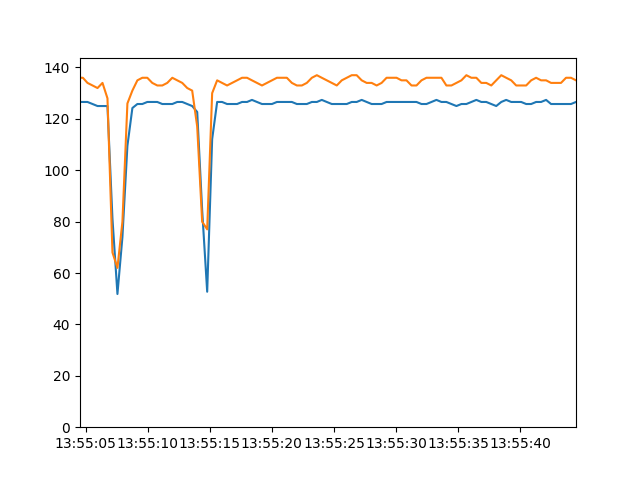

In [4]:
%matplotlib widget
plot_test()
pyplot.show()

### "%matplotlib widget"について

jupyterlab/jupyter/ipythonの`%matplotlib`マジックでは、引数として `inline`(既定値), `notebook`, `widget`を指定することができます。`widget`を指定した場合には、`matplotlib`の窓と同じような、移動／拡大／保存などの操作をnotebookからも実行できます。　`%matplotlib widget`を利用するためには、拡張機能を追加する必要があります。

```
pip install ipympl
```

インストールの詳細は、[ipympl](https://github.com/matplotlib/ipympl)をご覧ください。

### matplotlib animation：アニメーションとして表示する。

時間変化のグラフを動的なアニメーションとして表示してみます。
グラフのアニメーションを表示するために、matplotlibでは`animation`サブモジュールが提供されています。今回は`animation`の中の`FuncAnimation`クラスを使うことにします。
`FuncAnimation`のオブジェクトの生成には、
    * グラフを描画する`Figure`オブジェクトと
    * アニメーションの各フレームを更新するための関数を引数に与えます。
    * グラフを初期化するための関数 を`init_func`に与えることもできます。

In [45]:
# for widget, install ipympl with `pip install ipympl`
from arduino_utils import *

import datetime,logging
import matplotlib.pyplot as pyplot
from matplotlib.animation import FuncAnimation
import IPython
from IPython.display import display,HTML

# equivalent to rcParams['animation.html'] = 'html5'
#from matplotlib import rc
#rc('animation', html='html5')

def anim(dev, mxl=200):
    fig, ax = pyplot.subplots(1,1)
    ax.relim()
    ax.autoscale_view()
    lt=[]
    lcds=[]
    llum=[]
    
    def anim_plot(t1):
        nonlocal fig, ax, mxl, dev
        nonlocal lt, lcds, llum
        lines=ax.lines
        lt.append(datetime.datetime.now())
        lcds.append(getCds(dev))
        llum.append(getLum(dev))
        lt=lt[-mxl:]
        lcds=lcds[-mxl:]
        llum=llum[-mxl:]
        lines[0].set_data((lt,lcds))
        lines[1].set_data((lt,llum))
        ax.set_xlim(min(lt), max(lt))
        ax.set_ylim(0, 1.05*max(max(lcds),max(llum)))
        return  ax
    
    def setup():
        nonlocal fig, ax, dev
        nonlocal lt, lcds, llum
        logging.info("start setup")
        lt=[datetime.datetime.now()]
        lcds=[getCds(dev)]
        llum=[getLum(dev)]
        ax.plot(lt, lcds, lt, llum)
        return  ax
    
    ani=FuncAnimation(fig, 
                                anim_plot,init_func=setup,
                                frames=max(300,mxl),
                                interval=200, blit=False,
                                )
    return ani

In [46]:
%matplotlib widget 
if __name__ == "__main__":
    ttydev=glob.glob("/dev/tty*usb*")[0]
    if (not ttydev):
        import sys
        sys.exit()
    print(f"connecting to {ttydev}")
    with Serial(ttydev, baudrate=115200) as dev:
        wait_input(dev).decode('utf-8') # Arduinoの起動を待つ。
        ani=anim(dev,120)
        display(HTML(ani.to_html5_video())) # jupyterlabで表示させるためのおまじない
    pyplot.close()

connecting to /dev/tty.usbmodem11101


### 実時間での表示
前節ではアニメーションをファイルに保存して、そのファイルを端末上で表示しました。

以下のプログラムを実行することで、実時間に変化するグラフを表示することができます。
端末で、`python3 function_animation.py`を実行します。コメントを外すことによって、アニメーションを保存することもできます。保存するファイルの形式として、HTML5, gif, mp4がサポートされています。

In [32]:
%%file function_animation.py
#!python3
import datetime, logging
import matplotlib.pyplot as pyplot
import matplotlib.animation as mpl_anim

from arduino_utils import *

def anim(dev,mxl=200):
    fig, ax = pyplot.subplots(1,1)
    ax.relim()
    ax.autoscale_view()
    lt=[]
    lcds=[]
    llum=[]
    
    def anim_plot(values):
        nonlocal fig, ax, mxl, dev
        nonlocal lt, lcds, llum
        lines=ax.lines
        lt.append(values[0])
        lcds.append(values[1])
        llum.append(values[2])
        lt=lt[-mxl:]
        lcds=lcds[-mxl:]
        llum=llum[-mxl:]
        lines[0].set_data((lt,lcds))
        lines[1].set_data((lt,llum))

        ax.set_xlim(min(lt), max(lt) )
        ax.set_ylim(0, 1.05*max(max(lcds),max(llum)) )
        return  [ax,]

    def gen_function():
        nonlocal fig, ax, mxl, dev
        nonlocal lt, lcds, llum

        while 1:
            yield(
                datetime.datetime.now(),
                getCds(dev),
                getLum(dev)
            )

    def setup():
        nonlocal fig, ax, mxl,dev
        nonlocal lt, lcds, llum
        
        logging.info("start setup")
        lt=[datetime.datetime.now()]
        lcds=[getCds(dev)]
        llum=[getLum(dev)]
        ax.plot(lt, lcds, lt, llum)
        pyplot.draw()
        return  [ax,]
    
    ani=mpl_anim.FuncAnimation(fig, anim_plot, init_func=setup,
                               frames=gen_function, interval=200,
                               save_count=2*mxl, cache_frame_data=False,
                               )
    pyplot.show()
    # with open("_images/Figure_1.html","w") as f :
    #    f.write(ani.to_html5_video())
    # ani.save("_images/Figure_1.gif", writer="pillow")
    # ani.save("_images/Figure_1.mp4", writer="ffmpeg")
    return ani

def main():
    ttydev=glob.glob("/dev/tty*usb*")[0]
    if (not ttydev):
        import sys
        sys.exit()
    print(f"connecting to {ttydev}")
    with Serial(ttydev, baudrate=115200) as dev:
        wait_input(dev).decode('utf-8') # Arduinoの起動を待つ。
        ani=anim(dev,120)
    pyplot.close()
    
if __name__ == "__main__":
    main()

Overwriting function_animation.py


実行中に保存されたグラフのイメージ
![Figure1](./_images/Figure_1.png) 

### 実時間グラフの表示
端末を開き、

``` shell
python3 function_animation.py
```
を実行して、実時間でアニメーショングラフを表示します。
(グラフの窓を閉じるなどでプログラムの実行は停止されます。）

### アニメーションの再生
html形式で保存したアニメーションをノートブックの中で再生します。

webブラウザでhtmlファイルを開いてもアニメーションが再生されます。

In [33]:
import IPython
from IPython.display import display,HTML

display(HTML(open("_images/Figure_1.html").read()))

## 今日のまとめ

 * serial接続を使って、装置からデータを入出力する
 * 入手したデータ(デジタル値）を物理的に意味のある数値に変換する。
 * 入手したデータをテキスト／グラフ／アニメーションとして表示する。

今回で2021年度のPython入門講座は終了です。

テキストの資料は、

http://j-parc.jp/ctrl/documents/articles/

から入手可能です。(随時更新／追加　することがあります。）

録画資料もこちらから閲覧できるように整備する予定です(なお、MS teamsのゲストアカウントは取り消しとなる予定です。Streamも利用できなくなります。）

EPICS CAをPythonから利用するための講座を準備中です。準備が整いましたら、ご連絡いたします。

# 付録

[SCPI]: https://en.wikipedia.org/wiki/Standard_Commands_for_Programmable_Instruments
[IEE-488-2]: https://en.wikipedia.org/wiki/IEEE-488
[Requests module]: https://docs.python-requests.org/en/master/

## 装置制御に役立つその他のPythonモジュール
PCにはUSBの他にも WiFiやEthernetのネットワークインタフェース、USB、Bluetoothなどのインタフェース
が搭載されています。これらのインタフェースを使用して装置を制御するために利用可能なpythonモジュール
が存在します。これらの通信方法の中で、VXI11, HiSLIP, USBTMCは[SCPI(Standard Commands for Programmable Instruments)][SCPI]/[IEE-488-2(Part 2: Codes, Formats, Protocols and Common Commands)]規格に従ったコマンド体系を使っています。　Serial経由でも同様のコマンド体系を使った装置も多数存在します。


### ネットワーク経由

ネットワークに対応した様々な装置が存在します。

 * シリアル接続を単純にネットワークした様な、"raw socket"や"telnet protocol"を使う装置
     * raw socket -> `socket`
     * telnet -> `telnetlib`
 * HTTPサーバーを内蔵し、webページからの制御が可能な装置
     * web(http) -> `urllib.request`, [`Requests`][Requests module]
* 業界標準である、VXI11, HiSLIPといった規格に基づいた装置
     * VXI11 -> `python-vxi11` `PyVXI11`
     * HiSLIP -> `PyHiSLIP`

### USB

USB経由での制御に対応している装置は主に二つに分けられます。

 * USB-CDCおよびusb-TMCといった標準的なUSBのクラスドライバに対応した装置と
 * メーカー特有のドライバが必要な装置です。

メーカー特有のドライバが必要な装置をusbモジュールを使って、操作することは原理的には可能ですが、USBのパッケットレベルの通信制御が必要となります、そのメーカーからのデータの提供があればプログラム開発も可能ですが、そのハードルは高いものとなります(普通は公開してもらえない）。情報が入手できれば、pythonレベルで通信ソフトを開発することは可能です。

 * USB-CDC(Communication Device Class)はArduinoの例でつかった様に、シリアル接続の装置としてPCのOSに認識されます。

 * USB-TMC(Test and Measuremnet Class)の装置は、

[SCPI(Standard Commands for Programmable Instruments)][SCPI]/[IEE-488-2(Part 2: Codes, Formats, Protocols and Common Commands)] に従ったコマンドを送受信することで制御可能です。
多くのオシロスコープなどの機器はこの標準に対応しています。

 * usb-CDC -> pyserial 
 * usbtmc  -> phthon-usbtmc, PyUSBTMC
 * usb     -> pyusb

### Bluetooth/BLE

TTYデバイスとして認識されれば、pyserialで接続可能なはずです。シリアル通信の信号をBluetoothに変換するモジュールも存在するので、ここで使ったArduinoを無線化することも可能です。

[SCPI]: https://en.wikipedia.org/wiki/Standard_Commands_for_Programmable_Instruments
[IEE-488-2]: https://en.wikipedia.org/wiki/IEEE-488

## シリアル通信の歴史
シリアル通信では、データは時間にそって順次伝わっていく。パラレル通信では、複数の信号線を使うことで一組みのデータが同時に送信される。
電気信号を使った通信は、モールス符号を用いた電信に始まり、テレタイプをへて、現在に続いている。
計算機／装置間の通信としては、パラレル通信による高速化が発達したが、複数信号間の時間のずれ(スキュー）の問題から、再び通信方式として
シリアル方式が使われるようになっている。(USB, SPI, I2C, ...)

### モールス符号
アメリカ合衆国の発明家サミュエル・フィンレイ・ブリース・モールスは、1837年9月4日にニューヨーク大学で現在のものと全く異なった符号で電信実験を行い、ジョセフ・ヘンリー（プリンストン大学教授）の指導との協力の下、改良した符号と電信機との特許を1840年6月20日に取得した。　30 Words/minutes程度
短点と長点の組み合わせ及び、文字間／語間を表す空白時間が使われる。

モールス式通信の最初は紙テープを使ったもの。穿孔済みの紙テープから送信、紙テープに信号を印刷して解読した。
リレーの音から（人が）解読できる様になり、通信速度が向上した。

ちなみに、ベルによる電話の発明は1876年(特許取得）。

### テレタイプ
テレタイプの運用は1849年、フィラデルフィアとニューヨーク間で始まった[1]。

1901年、ドナルド・ミュレーがタイプライター状のキーボードの開発過程でボドーの符号体系に改良を加えた。
ミュレーはまた「制御文字」と呼ばれるコードとしてキャリッジ・リターン (CR) や改行コード (LF) を符号体系に加えた。NULL、BLANK、DELといったコードはボドーの符号体系から移動させられ、その値が長らく使われることになった。NULLやBLANKは送信中に何も送信していない状態を表すのに使われた。

1924年、Frederick G. Creed が創業した Creed & Company がテレタイプ端末市場に参入。1925年、Creed は Baudot Code を合理化したミュレーの符号体系についての特許を獲得し、1927年の新機種にそれを採用した。

### ASCII
ASCIIは、7桁の2進数で表すことのできる整数の数値のそれぞれに、大小のラテン文字や数字、英文でよく使われる記号などを割り当てた文字コードです。1963年6月17日に、American Standards Association（ASA、後のANSI）によって制定されました。TTYを制御するための制御コードも含まれています。


[Real World Instrumentation with Python]: J.M.Hughes, O'Reilly, 2011



### EIA-232(RS-232) 規格
USBが普及する以前に広くつかれていた規格。 DB-25pinあるいはDE-9pinのケーブルで機器(DTE:data terminal equipment)と通信装置(DCE:data communication equipment, MODEM:Modulator-Demodulator)を接続するために使われていた。
TxDおよびRxDの信号線の他に、DTR(Data Terminal Ready), DCD(Data Carrier Detect), DSR(Data Set Ready),RTS/RTR(Request To Send/Ready to Receive), CTS(Clear To Send) といった通信制御のための信号線を持っている。

![DCEとDTEの関係](./_images/EIA232_system_configuration.png)

![DCEとDTEの関係](./_images/EIA232_signal_connections.png)

### EIA-232(RS232-C) 信号の方向と接続の関係
初期のPCでは、EIA-232の信号(制御信号を含む）をサポートするために、DB-9コネクタが標準的に使われていました。制御信号を省くことで3芯のケーブル(Tx/Rx/GND)でも通信は可能となるので、その他のコネクタが使われる場合もありました。）

[DCEとDTEの関係]: ./_images/EIA232_signal_connections.png

###　クロスケーブルによるDTE-DTE接続
DTE-DTE間の距離によっては、ケーブルによる直接接続も可能です。この場合にはクロスケーブルと呼ばれる接続のケーブルが使われます。

### IEEE-488

パラレル接続の一例としてIEEE-488規格を紹介します。

IEEE-488規格はGPI-IB/HP-IBに起源をもつ、機器制御の国際規格です。現在のIEE-488規格はIEEE-488.1, IEEE-48.2の二つの規格に分かれています。IEEE-488.1はGP-IBの電気的な規格を定めています。一方、IEEE-488.2はこの規格に従う機器の制御で使われるコマンドやデータのフォーマット、標準的なコマンドについて規定しています。

[IEEE 488.1-1987 (IEEE Standard Digital Interface for Programmable Instrumentation)]: https://standards.ieee.org/ieee/488.1/715/

[IEEE 488.2-1992 IEEE Standard Codes, Formats, Protocols, and Common Commands for Use With IEEE Std 488.1-1987, IEEE Standard Digital Interface for Programmable Instrumentation]: https://standards.ieee.org/ieee/488.2/718/

### 変換ケーブルの例
シリアル接続用ケーブルの一例として、USB-Serial変換ケーブルの一例（写真左）を示します。ケーブルの一端にUSB- Aコネクタ、反対の一端にはDB-9コネクタがUSB-Serial変換機能を持つ中央部を経由して接続されています。
写真右は同様のUSB-GPIB変換ケーブルです。GP-IBのコネクタはアンフェノール社が設計した24ピンのマイクロリボンコネクタになっています。GP-IBはパラレル接続ですので、EIA-232に比べ信号線の数が増えています。
![USB Serial converter](./_images/cables-connectors.png)

## CdSセルとThermistor
### CdS（硫化カドミウム)セル
* 光量($Lum$)が**増える**と抵抗値($R$)が**下がる**。
* $ R/R_0= K/Lum $

### Thermistor
* 温度が**上がる**と抵抗値が**下がる**。
* $R=R_0 e^{B\times(1/T - 1/T_0)}=R_1*\exp{T/t}$, ただし$T=t+273.15$は絶対温度

![試験装置素子接続図](_images/ArduinoTestCircuit.png)

|pin| signal|
|:-:| :-: |
|D3(PWM) | 3-LED(R) | 
|D5(PWM) | 3-LED(G) | 
|D6(PWM) | 3-LED(B) | 
|D9(PWM) | LED | 
|D10(PWM) | LED | 
|D7(In) | Button(SW) | 
|D2(out) | Buzzer | 
|A0 | Cds | 
|A1 | Thermistor | 
|A5 | Vdd | 
|D８/D12 | 傾き(Tilt)スイッチ | 

# asyncio (to be completed)

In [34]:
# asynio version

import asyncio
from serial import Serial

async def async_wait_input(port,msg=None):
    if msg:
        port.write(msg)
    resp=port.read_until(b'*')
    return resp

async def async_main(n=3,wait=0.2):
    port=Serial("/dev/tty.usbmodem11101", baudrate=115200)
    await async_wait_input(port)
    for i in range(n):
        for msg,stat in ((b"a300","on"),(b"a3ff","off")):
            resp=await async_wait_input(port, msg)
            print(f"turn {stat} {time.strftime('%X')} {resp.decode('utf-8')}")
            await asyncio.sleep(wait)
 
waitable=async_main()
print(f"started at {time.strftime('%x %X')}") 
#await asyncio.create_task(async_main(10,0.05))
await waitable
print(f"finished at {time.strftime('%x %X')}")

started at 03/29/22 10:51:37
turn on 10:51:38 a30*
turn off 10:51:39 a3FF*
turn on 10:51:39 a30*
turn off 10:51:39 a3FF*
turn on 10:51:40 a30*
turn off 10:51:40 a3FF*
finished at 03/29/22 10:51:40


In [35]:
import asyncio
async def foo():
    await asyncio.sleep(5)
    print("done")
await foo()

done


In [36]:
import asyncio
import random
async def foo(n):
    wait=random.randint(1,5)
    print(f"start {n} wait:{wait}")
    await asyncio.sleep(wait)  # wait 1~5s before continuing
    print(f"n: {n}!")

async def asyn_main():
    tasks = [foo(3), foo(2), foo(1)]
    await asyncio.gather(*tasks)

await asyn_main()

start 3 wait:4
start 2 wait:4
start 1 wait:3
n: 1!
n: 3!
n: 2!


In [37]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

from matplotlib import animation
from IPython.display import HTML

# mode parameteres
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 305.0     # Coolant temperature [K]

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

# create a set of initial conditions
ICs = [[cA0,T0] for cA0 in [0] for T0 in np.linspace(295,480,19)]
ICs += [[cA0,T0] for cA0 in np.linspace(0,1,21) for T0 in [290]]
ICs += [[cA0,T0] for cA0 in [1] for T0 in np.linspace(295,475,18)]

# perform simulations for each of the initial conditions
t = np.linspace(0,10.0,800)
sols = [odeint(deriv,IC,t) for IC in ICs]

# create background figure and axes
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,1))
ax.set_ylim((290,480))
ax.set_xlabel('Concentration [gmol/liter]')
ax.set_ylabel('Temperature [K]')
ax.set_title('Exothermic Reactor with Tc = {0:.1f} K'.format(Tc))

# create lists of colors, points, and lines
colors = sns.color_palette("husl",len(sols))
pts = sum([ax.plot([],[],'o',color=colors[k],ms=15) for k in range(0,len(sols))],[])
lines = sum([ax.plot([],[],color=colors[k],lw=2) for k in range(0,len(sols))],[])

# don't show the plain background
plt.close()

# define function to draw each frame
def drawframe(n):
    for k in range(0,len(sols)):
        C,T = sols[k].T
        pts[k].set_data(C[n],T[n])
        lines[k].set_data(C[:n],T[:n])
    return pts + lines

from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

# create animiation object and render in HTML video
anim = animation.FuncAnimation(fig, drawframe, frames=len(t), interval=20, blit=True)

HTML(anim.to_html5_video())

#anim

In [38]:
import random
help(random.randint)

Help on method randint in module random:

randint(a, b) method of random.Random instance
    Return random integer in range [a, b], including both end points.

